# README

Tentativo di creare una rete convoluzione multipla in cui venga messo in relazione anche l'età del paziente per prevedere i giorni di sopravvivenza

In [1]:
from numpy.random import seed
seed(1)

from tensorflow import set_random_seed
set_random_seed(2)

# Data Collection

Collezioniamo i dati di T1, T2 e FLAIR più un dataset per l'età

In [2]:
from gliomi import *

Using TensorFlow backend.


In [3]:
def get_datasets(datasets_path):
    result = []
    for dataset_path in datasets_path:
        with open(dataset_path, "rb") as file:
            result.append(pickle.load(file))
    return result

In [4]:
tumor_crop = "/data/RMN/dataset-gliomi-cnn/datasets-tumor-crop"
full_brain = "/data/RMN/dataset-gliomi-cnn/datasets-full-brain"

datasets = get_datasets([
    f"{full_brain}/FLAIR-64-100.pickle",
    f"{tumor_crop}/FLAIR-64-100.pickle",
    f"{full_brain}/MPRAGE-64-100.pickle",
    f"{tumor_crop}/MPRAGE-64-100.pickle"
])

## Get età and survivor data

In [5]:
import pandas as pd

survivor_age_survdays = pd.read_csv("dataset-age-survdays.csv")

In [6]:
survivor_age_survdays

,Subject,Path,Age,Days
0,Alessandrini,ALESSANDRINI_GLAUCO,75,360
1,Angeloni,ANGELONI_GIUSEPPINA,67,850
2,Assanto,ASSANTO_MARIA,62,325
3,Asta,ASTA_G,48,789
4,Bagnoli,BAGNOLI_VINCENZO,73,541
...,...,...,...,...
150,Vitulano,VITULANO_RITA,63,viva
151,Zampella,ZAMPELLA_A,49,viva
152,Zanatta,ZANATTA_CARLO,66,577
153,Zangari,ZANGARI_ALDO,62,11


In [7]:
survivor_age_survdays = survivor_age_survdays.replace('viva', -1)
survivor_age_survdays = survivor_age_survdays.replace('vivo', -1)
survivor_age_survdays['Days'] = survivor_age_survdays['Days'].astype(np.float)

In [8]:
survivor_age_survdays = survivor_age_survdays.replace(-1, np.max(survivor_age_survdays['Days']))

In [9]:
"""
Compute the intersection of all keys from a given set of dataset
"""
def subjects_in_datasets(datasets): 
    result = None
    for dataset in datasets:
        if result is None:
            result = list(dataset.keys())
        else:
            result = np.intersect1d(list(dataset.keys()), result)
    return result

In [10]:
intersection_subjects = subjects_in_datasets(datasets)

In [11]:
survivor = {}
eta = {}

for subject, e, sopr in zip(survivor_age_survdays['Path'], survivor_age_survdays['Age'], survivor_age_survdays['Days']):
    if subject in intersection_subjects:
        survivor[subject] = sopr
        eta[subject] = e

In [12]:
from functools import reduce

all_subjects = reduce(np.union1d, map(lambda x: np.array(list(x.keys())), datasets))

In [13]:
missing = []
for subject in all_subjects:
    if subject not in survivor:
        # print("Missing", subject)
        missing.append(subject)

In [14]:
for miss in missing:
    print("remove:", miss)
    for dataset in datasets:
        if miss in dataset:
            del dataset[miss]

remove: BIANCHI_S
remove: FARELLA_PAOLO
remove: RUFINI_A


In [15]:
len(datasets[0].keys()), len(datasets[1].keys()), len(datasets[2].keys()), len(eta.keys()), len(survivor.keys())

(154, 154, 154, 154, 154)

# Splitting Data

In [16]:
from sklearn.model_selection import train_test_split

"""
Establish the intersection of all keys and return train and test subjects
"""
def get_split(datasets, test_size=0.2, random_state=42):
    
    # Intersection of subjects from datasets
    subjects = reduce(np.intersect1d, map(lambda x: np.array(list(x.keys())), datasets))
    
    print("Subject in intersection:", subjects.shape[0])
    
    indexes = list(range(subjects.shape[0]))

    train_index, test_index = train_test_split(
        indexes, 
        test_size=test_size, 
        random_state=random_state)

    train_subjects = subjects[train_index]
    test_subjects = subjects[test_index]
    
    return train_subjects, test_subjects

In [17]:
def get_image_data(dataset, subjects):
    result = []
    for subject in subjects:
        result.append([dataset[subject][0]])
    return np.concatenate(result, axis=0)   

In [18]:
def get_dict_data(dataset, subjects):
    result = []
    for subject in subjects:
        result.append(dataset[subject])
    return np.array(result)

In [19]:
def get_age_data(dataset, subjects):
    result = []
    for subject in subjects:
        result.append(dataset[subject] / 100.0)
    return np.array(result)

In [20]:

def get_survivor_data(dataset, subjects):
    
    threshold_day = 360
    
    survivor_days = get_dict_data(dataset, subjects)
    survivor_days[survivor_days <= threshold_day] = 1
    survivor_days[survivor_days > threshold_day] = 0
    
    return survivor_days
    
    # segments = np.floor(get_dict_data(dataset, subjects) / (365.0 / 4.0))
    # segments[segments > 6] = 6
    # return to_categorical(segments)

In [21]:
datasets = [datasets[0], datasets[1], datasets[2], datasets[3], eta, survivor]

In [22]:
train, test = get_split(datasets)

Subject in intersection: 154


In [23]:
Xs_train = []
for i, dataset in enumerate(datasets[:4]):
    Xs_train.append(get_image_data(dataset, train))
Xs_train = np.array(Xs_train)

In [24]:
Xs_test = []
for i, dataset in enumerate(datasets[:4]):
    Xs_test.append(get_image_data(dataset, test))
Xs_test = np.array(Xs_test)

In [25]:
from keras.utils import to_categorical

y_train = to_categorical(get_survivor_data(survivor, train))
y_test = to_categorical(get_survivor_data(survivor, test))

In [26]:
Xs_test.shape

(4, 31, 64, 64, 1)

In [27]:
np.stack([Xs_test[0,:,:,:,0], Xs_test[1,:,:,:,0]], axis=3).shape

# 

(31, 64, 64, 2)

# Modelling

In [28]:
side = 64

In [29]:
from gliomi.models import CNNCombinedModel, GliomiNature2019

In [30]:
flair_full_brain = GliomiNature2019(128, classes=64, input_shape=(side,side,1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [31]:
flair_tumor_crop = GliomiNature2019(128, classes=64, input_shape=(side,side,1))

In [32]:
mprage_full_brain = GliomiNature2019(128, classes=64, input_shape=(side,side,1))

In [33]:
mprage_tumor_crop = GliomiNature2019(128, classes=64, input_shape=(side,side,1))

In [34]:
model = CNNCombinedModel([flair_full_brain, flair_tumor_crop, mprage_full_brain, mprage_tumor_crop])

In [35]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 50

batch_size = 16

opt = Adam(lr=1e-3 / 10, decay=1e-3 / epochs)

# model.compile(optimizer="adam", loss="mse", metrics=['categorical_accuracy'])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['categorical_accuracy'])

# model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

print("[INFO] training model...")

early_stopping_callback = EarlyStopping(monitor='loss', patience=50)

from keras.preprocessing.image import ImageDataGenerator

model.fit(
    x=Xs_train.tolist(), y=y_train,
    callbacks=[early_stopping_callback],
    validation_data=(Xs_test.tolist(), y_test),
    batch_size=batch_size,
    epochs=epochs)

[INFO] training model...
Train on 123 samples, validate on 31 samples
Epoch 1/50
123/123 [==============================] - 11s 92ms/sample - loss: 0.6943 - categorical_accuracy: 0.4634 - val_loss: 0.6915 - val_categorical_accuracy: 0.5484
Epoch 2/50
123/123 [==============================] - 1s 8ms/sample - loss: 0.6857 - categorical_accuracy: 0.5447 - val_loss: 0.6923 - val_categorical_accuracy: 0.5484
Epoch 3/50
123/123 [==============================] - 1s 9ms/sample - loss: 0.6578 - categorical_accuracy: 0.5528 - val_loss: 0.7010 - val_categorical_accuracy: 0.5484
Epoch 4/50
123/123 [==============================] - 1s 8ms/sample - loss: 0.6155 - categorical_accuracy: 0.7642 - val_loss: 0.7164 - val_categorical_accuracy: 0.4516
Epoch 5/50
123/123 [==============================] - 1s 8ms/sample - loss: 0.5342 - categorical_accuracy: 0.8374 - val_loss: 0.7032 - val_categorical_accuracy: 0.5161
Epoch 6/50
123/123 [==============================] - 1s 8ms/sample - loss: 0.4829 - cat

123/123 [==============================] - 1s 8ms/sample - loss: 2.8916e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9900 - val_categorical_accuracy: 0.5484
Epoch 49/50
123/123 [==============================] - 1s 8ms/sample - loss: 2.7510e-04 - categorical_accuracy: 1.0000 - val_loss: 0.9987 - val_categorical_accuracy: 0.5806
Epoch 50/50
123/123 [==============================] - 1s 8ms/sample - loss: 2.6769e-04 - categorical_accuracy: 1.0000 - val_loss: 1.0096 - val_categorical_accuracy: 0.6129


In [36]:
def sensitivity(X, y):
    ok = 0
    ko = 0
    for a, b in zip(model.predict(X), y):
        # print(np.round(a), b, (np.all(np.round(a) == b)))
        if np.all(np.round(a) == b):
            ok = ok + 1
        else:
            ko = ko + 1
    return (ok / (ok + ko) * 100.0), ok, ko

In [37]:
print("Train Sensitivity")
train_sensitivity = sensitivity(Xs_train.tolist(), y_train)
print("ok:", train_sensitivity[1], "ko:", train_sensitivity[2], train_sensitivity[0], "%")

print("Test Sensitivity")
test_sensitivity = sensitivity(Xs_test.tolist(), y_test)
print("ok:", test_sensitivity[1], "ko:", test_sensitivity[2], test_sensitivity[0], "%")

Train Sensitivity
ok: 70 ko: 53 56.91056910569105 %
Test Sensitivity
ok: 19 ko: 12 61.29032258064516 %


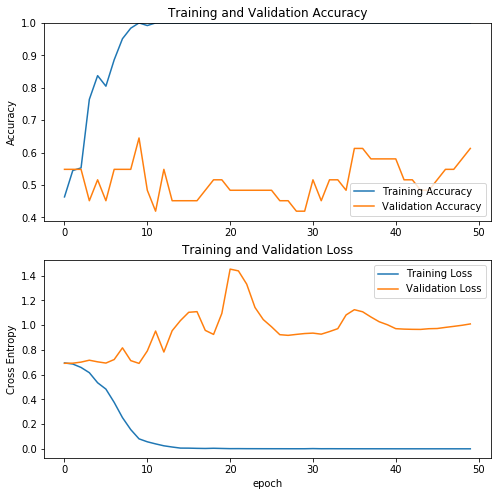

In [38]:
"""
Save results in plot
"""
def plot_history(history):

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    # plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.show()

plot_history(model.history)

# Save model after training

In [ ]:
# model.save(f"4-channels-{side}.h5")

In [ ]:
model.summary()

# Feature extractor

In [ ]:
feature_extractor = Model(model.inputs, model.get_layer("concatenate").output)

# SVM

In [ ]:
"""
Establish the intersection of all keys and return train and test subjects
"""
def get_fake_validation_dataset(datasets, test_size=0.2, random_state=42):
    
    # Intersection of subjects from datasets
    subjects = reduce(np.intersect1d, map(lambda x: np.array(list(x.keys())), datasets))
    
    indexes = list(range(subjects.shape[0]))

    train_index, test_index = train_test_split(
        indexes, 
        test_size=test_size, 
        random_state=random_state)

    train_subjects = subjects[train_index]
    test_subjects = subjects[test_index]
    
    ds = {}
    for subject in test_subjects:
        ds[subject] = 1
    
    return ds

In [ ]:
def get_svm_split(random_state=42):
    
    # Validation dataset subjects
    fake_ds = get_fake_validation_dataset(datasets)
    
    train, test = get_split([fake_ds], random_state=random_state)
    
    Xs_train = []
    for i, dataset in enumerate(datasets[:4]):
        Xs_train.append(get_image_data(dataset, train))
    Xs_train = np.array(Xs_train)

    Xs_test = []
    for i, dataset in enumerate(datasets[:4]):
        Xs_test.append(get_image_data(dataset, test))
    Xs_test = np.array(Xs_test)

    y_train = np.array(get_survivor_data(survivor, train))
    y_test = np.array(get_survivor_data(survivor, test))

    eta_train = np.array(get_age_data(eta, train))
    eta_test = np.array(get_age_data(eta, test))
    
    return Xs_train, y_train, Xs_test, y_test, eta_train, eta_test

In [ ]:
from sklearn import svm

def evaluate_model_SVM(feature_extractor, times):
    
    scores = []
    
    for random_state in range(times):
        
        X_train, y_train, X_test, y_test, eta_train, eta_test = get_svm_split(random_state)
            
        features_train = feature_extractor.predict(X_train.tolist())

        features_test = feature_extractor.predict(X_test.tolist())
            
        clf = svm.SVC()

        clf.fit(features_train, y_train)

        score = clf.score(features_test, y_test)

        print(random_state, ":", score)

        scores.append(score)

    return np.array(scores)

In [ ]:
evaluate_model_SVM(feature_extractor, 10)

In [ ]:
array([93.54, 87.09, 90.32, 80.64, 93.54, 93.54, 96.77, 93.54, 93.54, 90.32])

In [ ]:
l = np.array([0.71428571, 0.57142857, 0.42857143, 0.57142857, 0.42857143,
       0.42857143, 0.42857143, 0.28571429, 0.42857143, 0.42857143])

In [ ]:
np.mean(l)

In [39]:
from numba import cuda
cuda.select_device(0)
cuda.close()